In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.patches as mpatches

In [3]:
df_sales = pd.read_csv('Sales_Data05.csv')
df_member = pd.read_csv('Member_Data.csv',encoding='cp949')
df_product = pd.read_csv('Product_Data.csv')

In [5]:
# 1. 데이터 전처리 및 고객별 피처 엔지니어링
# =============================================================================

# --- df_sales 전처리 ---
# 주문일시와 배송완료일을 datetime으로 변환
df_sales['주문일시'] = pd.to_datetime(df_sales['주문일시'], errors='coerce')
df_sales['배송완료일'] = pd.to_datetime(df_sales['배송완료일'], errors='coerce')

# 배송기간 계산 (일수): 배송완료일 - 주문일시
df_sales['배송기간'] = (df_sales['배송완료일'] - df_sales['주문일시']).dt.days

# 배송지연여부 생성: 배송기간이 2일 초과하면 1, 아니면 0
delay_threshold = 2
df_sales['배송지연여부'] = (df_sales['배송기간'] > delay_threshold).astype(int)

# --- 고객별 집계 ---
# (a) 총 주문 건수와 총 구매 금액, 배송지연 주문 수 집계 (df_sales 기준)
customer_orders = df_sales.groupby('회원번호').agg(
    total_orders=('회원번호', 'count'),
    total_purchase_amount=('구매금액', 'sum'),
    shipping_delay_count=('배송지연여부', 'sum')
).reset_index()
customer_orders['shipping_delay_freq'] = customer_orders['shipping_delay_count'] / customer_orders['total_orders']

# (b) 고객별 평균 구매 주기 계산 (일 단위)
def compute_avg_cycle(dates):
    dates = dates.sort_values()
    if len(dates) < 2:
        return np.nan
    diffs = dates.diff().dropna().dt.days
    return diffs.mean()

purchase_cycle = df_sales.groupby('회원번호')['주문일시'].apply(compute_avg_cycle).reset_index(name='avg_purchase_cycle')

# (c) 고객별 마지막 주문일 계산
last_order = df_sales.groupby('회원번호')['주문일시'].max().reset_index(name='last_order_date')

# (d) 고객 피처 병합: 주문 집계, 평균 구매 주기, 마지막 주문일
customer_features = customer_orders.merge(purchase_cycle, on='회원번호', how='left')
customer_features = customer_features.merge(last_order, on='회원번호', how='left')

# --- df_member 전처리 ---
# 구독여부 전처리: 문자열 소문자화, 공백 제거 및 매핑 ('true', 'yes' -> True; 'false', 'no' -> False)
df_member['구독여부'] = df_member['구독여부'].astype(str).str.strip().str.lower()
mapping_dict = {'true': True, 'yes': True, 'false': False, 'no': False}
df_member['구독여부'] = df_member['구독여부'].map(mapping_dict)

# --- 고객 피처에 회원 정보(구독여부) 병합 ---
customer_features = customer_features.merge(df_member[['회원번호', '구독여부']], on='회원번호', how='left')

# 결측치 처리: avg_purchase_cycle의 NaN은 중앙값으로 대체
customer_features['avg_purchase_cycle'] = customer_features['avg_purchase_cycle'].fillna(customer_features['avg_purchase_cycle'].median())


In [6]:
# 2. 라벨 생성: 목표 변수 설정
# =============================================================================

# 모델 1: 구독 확률 예측
# 이미 customer_features에 '구독여부' 컬럼이 있으므로, 목표 변수는 그대로 사용.
# NaN 처리: 구독여부가 NaN인 경우 미구독(0)으로 처리
customer_features['구독여부'] = customer_features['구독여부'].fillna(False).astype(int)

# 모델 2: 자주 구매(구매주기 n개월 이하) 예측
# 기준: n개월을 일(day)로 환산 (예: n=3개월 -> 약 90일 이하)
n_months = 3
threshold_days = n_months * 30  # 약 90일
customer_features['frequent_buyer'] = (customer_features['avg_purchase_cycle'] <= threshold_days).astype(int)


C:\Users\sylvi\AppData\Local\Temp\ipykernel_11588\3427967024.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_features['구독여부'] = customer_features['구독여부'].fillna(False).astype(int)


In [7]:
# 3. 모델 입력 변수 구성
# =============================================================================

# 선택 피처: 구매 내역, 구매 주기, 배송지연 빈도
feature_cols = ['total_orders', 'total_purchase_amount', 'avg_purchase_cycle', 'shipping_delay_freq']

# -----------------------
# 모델 1: 구독 확률 예측 모델 (목표: '구독여부')
# -----------------------
X_sub = customer_features[feature_cols]
y_sub = customer_features['구독여부']

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)

# 오버샘플링: SMOTE 적용
smote = SMOTE(random_state=42)
X_train_sub_res, y_train_sub_res = smote.fit_resample(X_train_sub, y_train_sub)

print("구독 모델 - 원본 학습 데이터 클래스 분포:")
print(y_train_sub.value_counts())
print("구독 모델 - 오버샘플링 후 학습 데이터 클래스 분포:")
print(pd.Series(y_train_sub_res).value_counts())

# 로지스틱 회귀 모델 학습 (class_weight='balanced' 추가)
log_reg_sub = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg_sub.fit(X_train_sub_res, y_train_sub_res)

y_pred_sub = log_reg_sub.predict(X_test_sub)
y_pred_proba_sub = log_reg_sub.predict_proba(X_test_sub)[:, 1]

print("\n----- 구독 확률 예측 모델 (오버샘플링 적용) -----")
print("혼동 행렬:")
print(confusion_matrix(y_test_sub, y_pred_sub))
print("\n분류 리포트:")
print(classification_report(y_test_sub, y_pred_sub))
print("ROC AUC Score (구독 모델):", roc_auc_score(y_test_sub, y_pred_proba_sub))

# -----------------------
# 모델 2: 자주 구매 (구매주기 n개월 이하) 예측 모델 (목표: 'frequent_buyer')
# -----------------------
X_freq = customer_features[feature_cols]
y_freq = customer_features['frequent_buyer']

X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y_freq, test_size=0.3, random_state=42)

# 자주 구매 고객의 경우, 극단적인 불균형이 있을 수 있으므로 SMOTE 적용
smote_freq = SMOTE(random_state=42)
X_train_freq_res, y_train_freq_res = smote_freq.fit_resample(X_train_freq, y_train_freq)

print("\n자주 구매 모델 - 원본 학습 데이터 클래스 분포:")
print(y_train_freq.value_counts())
print("자주 구매 모델 - 오버샘플링 후 학습 데이터 클래스 분포:")
print(pd.Series(y_train_freq_res).value_counts())

log_reg_freq = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg_freq.fit(X_train_freq_res, y_train_freq_res)

y_pred_freq = log_reg_freq.predict(X_test_freq)
y_pred_proba_freq = log_reg_freq.predict_proba(X_test_freq)[:, 1]

print("\n----- 자주 구매 (구매주기 n개월 이하) 예측 모델 (오버샘플링 적용) -----")
print("혼동 행렬:")
print(confusion_matrix(y_test_freq, y_pred_freq))
print("\n분류 리포트:")
print(classification_report(y_test_freq, y_pred_freq))
print("ROC AUC Score (자주 구매 모델):", roc_auc_score(y_test_freq, y_pred_proba_freq))


구독 모델 - 원본 학습 데이터 클래스 분포:
구독여부
0    7549
1    1229
Name: count, dtype: int64
구독 모델 - 오버샘플링 후 학습 데이터 클래스 분포:
구독여부
0    7549
1    7549
Name: count, dtype: int64

----- 구독 확률 예측 모델 (오버샘플링 적용) -----
혼동 행렬:
[[ 753 2485]
 [ 102  422]]

분류 리포트:
              precision    recall  f1-score   support

           0       0.88      0.23      0.37      3238
           1       0.15      0.81      0.25       524

    accuracy                           0.31      3762
   macro avg       0.51      0.52      0.31      3762
weighted avg       0.78      0.31      0.35      3762

ROC AUC Score (구독 모델): 0.511859408078684

자주 구매 모델 - 원본 학습 데이터 클래스 분포:
frequent_buyer
1    8689
0      89
Name: count, dtype: int64
자주 구매 모델 - 오버샘플링 후 학습 데이터 클래스 분포:
frequent_buyer
1    8689
0    8689
Name: count, dtype: int64

----- 자주 구매 (구매주기 n개월 이하) 예측 모델 (오버샘플링 적용) -----
혼동 행렬:
[[  46    0]
 [   0 3716]]

분류 리포트:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
      

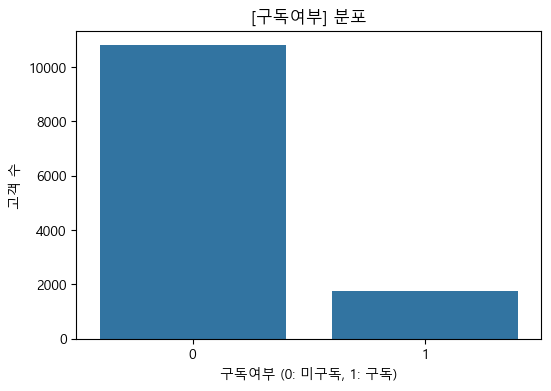

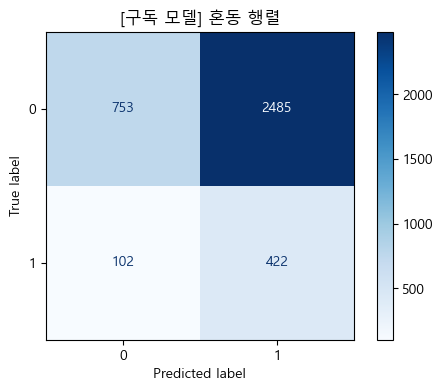

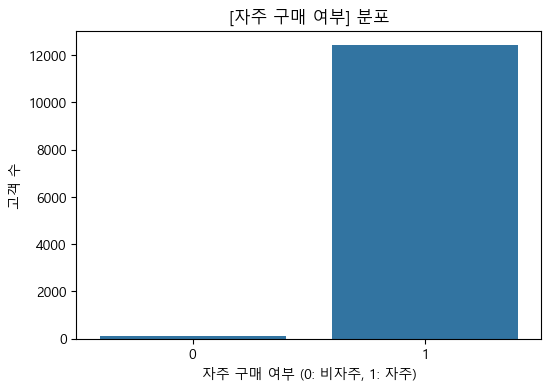

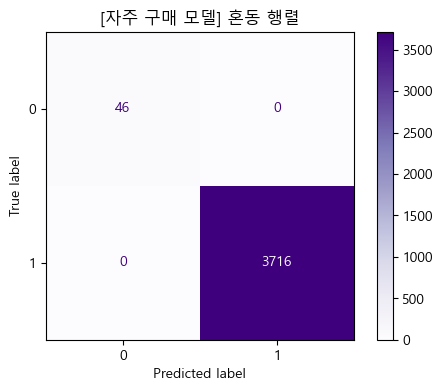

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams['font.family'] = 'Malgun Gothic'

# ----------------------------------------

# 1. 구독여부(0: 미구독, 1: 구독) 분포 시각화
plt.figure(figsize=(6, 4))
sns.countplot(data=customer_features, x='구독여부')
plt.title('[구독여부] 분포')
plt.xlabel('구독여부 (0: 미구독, 1: 구독)')
plt.ylabel('고객 수')
plt.show()

# 2. 구독 모델 혼동 행렬
fig, ax = plt.subplots(figsize=(6, 4))
cm_sub = confusion_matrix(y_test_sub, y_pred_sub)
disp_sub = ConfusionMatrixDisplay(confusion_matrix=cm_sub, display_labels=[0, 1])
disp_sub.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('[구독 모델] 혼동 행렬')
plt.show()

# 3. 자주 구매여부(0: 비자주, 1: 자주) 분포 시각화
plt.figure(figsize=(6, 4))
sns.countplot(data=customer_features, x='frequent_buyer')
plt.title('[자주 구매 여부] 분포')
plt.xlabel('자주 구매 여부 (0: 비자주, 1: 자주)')
plt.ylabel('고객 수')
plt.show()

# 4. 자주 구매 모델 혼동 행렬
fig, ax = plt.subplots(figsize=(6, 4))
cm_freq = confusion_matrix(y_test_freq, y_pred_freq)
disp_freq = ConfusionMatrixDisplay(confusion_matrix=cm_freq, display_labels=[0, 1])
disp_freq.plot(ax=ax, cmap='Purples', values_format='d')
ax.set_title('[자주 구매 모델] 혼동 행렬')
plt.show()


***<인사이트 도출>***

In [ ]:
1. 월별 판매 추이 분석

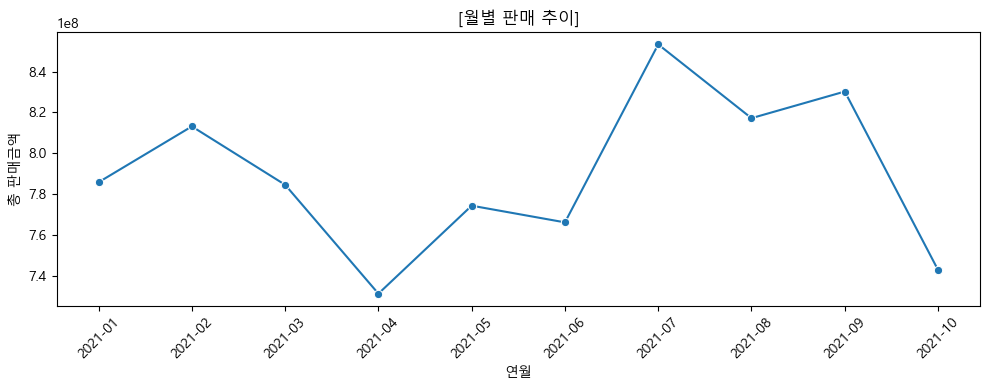

In [10]:
# 1. 주문일시를 datetime으로 변환
df_sales['주문일시'] = pd.to_datetime(df_sales['주문일시'], errors='coerce')

# 2. 연-월 단위로 집계: 월별 총 판매금액
df_sales['연월'] = df_sales['주문일시'].dt.to_period('M')
monthly_sales = df_sales.groupby('연월')['구매금액'].sum().reset_index()
monthly_sales['연월'] = monthly_sales['연월'].astype(str)  # 그래프 표시용 str 변환

# 3. 월별 판매 추이 시각화
plt.figure(figsize=(10, 4))
sns.lineplot(data=monthly_sales, x='연월', y='구매금액', marker='o')
plt.title('[월별 판매 추이]')
plt.xlabel('연월')
plt.ylabel('총 판매금액')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- 분석 결과 (그래프 설명):
그래프를 통해 월별 총 판매금액의 증감 추이를 한눈에 파악할 수 있습니다. 예컨대 특정 달(예: 2021-02, 2021-10)에 판매금액이 급증하거나 감소하는 패턴을 발견할 수 있습니다.

- 메시지 (비즈니스 관점):
● 판매금액이 급증한 달은 어떤 프로모션/이벤트가 있었는지, 특정 제품(계절 상품, 명절 선물 등)의 수요가 증가했는지 살펴볼 필요가 있습니다.
● 판매가 급감한 달에는 배송 지연이나 재고 문제, 혹은 외부 시장 이슈(예: 원자재 가격 상승 등)가 영향을 미쳤는지 확인해보면 좋습니다.
● 이를 통해 향후 프로모션 시점이나 재고 관리 계획을 세우는 데 활용할 수 있습니다.

2. 제품별 판매 상위 TOP 10

C:\Users\sylvi\AppData\Local\Temp\ipykernel_11588\1215943449.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_products, x='구매금액', y='물품명', palette='Blues_r')


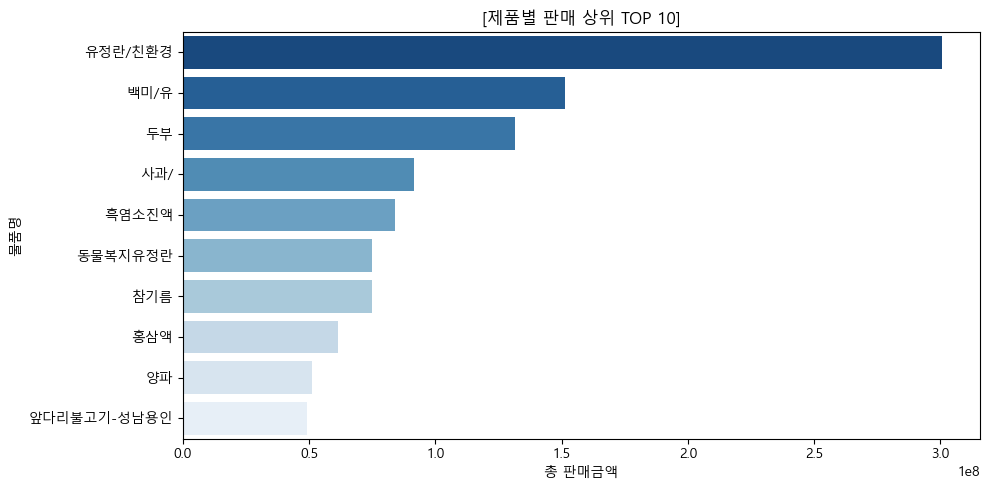

In [11]:
# 1. df_sales와 df_product를 제품번호로 조인
df_merged = pd.merge(df_sales, df_product, on='제품번호', how='left')

# 2. 제품번호(또는 물품명)별 판매금액 합계 계산
top_products = df_merged.groupby('물품명')['구매금액'].sum().reset_index().sort_values(by='구매금액', ascending=False)

# 3. 상위 10개 제품 추출
top10_products = top_products.head(10)

# 4. 막대 그래프로 시각화
plt.figure(figsize=(10, 5))
sns.barplot(data=top10_products, x='구매금액', y='물품명', palette='Blues_r')
plt.title('[제품별 판매 상위 TOP 10]')
plt.xlabel('총 판매금액')
plt.ylabel('물품명')
plt.tight_layout()
plt.show()


- 분석 결과 (그래프 설명):
그래프에서 상위 10개 제품이 전체 매출에서 차지하는 비중을 확인할 수 있습니다.
특정 제품이 압도적으로 높은 매출을 기록하거나, 비슷한 판매금액을 보이는 제품군이 다수일 수 있습니다.

- 메시지 (비즈니스 관점):
● 매출 상위 제품에 대한 집중적인 마케팅/프로모션 강화로 단기 매출 상승을 노릴 수 있습니다.
● 반면 매출이 특정 제품에 편중되어 있다면, 리스크 분산을 위해 다른 제품군의 판매 확대 전략이 필요할 수 있습니다.
● 신규 제품 개발이나 협업(예: 유사 제품 라인업 보강)을 고려하는 근거로도 활용 가능합니다.

3. 회원 상태 및 구독 여부 분포

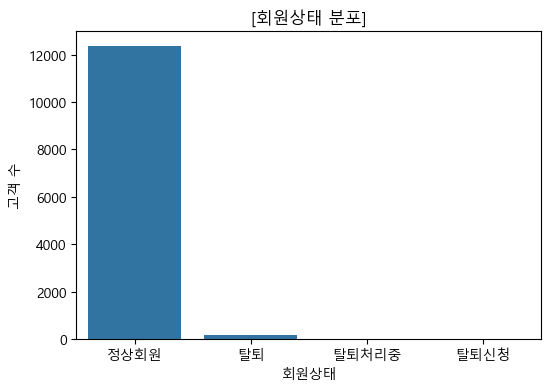

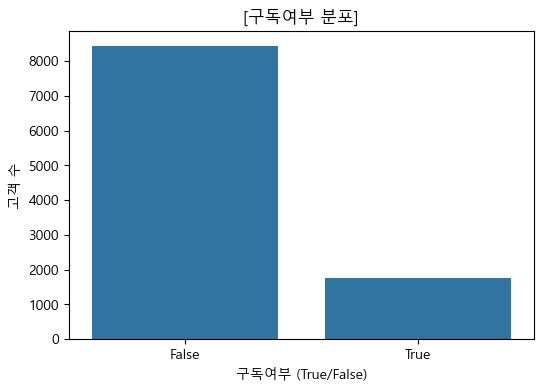

In [12]:
# 1. 회원상태 분포 시각화
plt.figure(figsize=(6,4))
sns.countplot(data=df_member, x='회원상태')
plt.title('[회원상태 분포]')
plt.xlabel('회원상태')
plt.ylabel('고객 수')
plt.show()

# 2. 구독여부 분포 시각화
plt.figure(figsize=(6,4))
sns.countplot(data=df_member, x='구독여부')
plt.title('[구독여부 분포]')
plt.xlabel('구독여부 (True/False)')
plt.ylabel('고객 수')
plt.show()


- 분석 결과 (그래프 설명):
● 회원상태: 정상회원, 탈퇴, 휴면회원 등 분포를 확인할 수 있습니다.
● 구독여부: 실제 구독을 유지 중인 회원이 얼마나 되는지, 
구독을 해지했거나 처음부터 구독하지 않은 비중이 얼마나 되는지 파악 가능.

- 메시지 (비즈니스 관점):
● 탈퇴 또는 휴면회원 비율이 높다면, 이탈 방지 프로그램(맞춤 할인, 휴면 복귀 캠페인 등) 운영이 시급
● 구독 유지 회원 비율이 낮다면, 
정기구독 모델 개선이나 구독 혜택(배송비 절감, 멤버십 포인트 적립 강화 등)을 강화할 여지가 있다.

In [ ]:
4. 구매 주기 분포 및 배송 지연 경

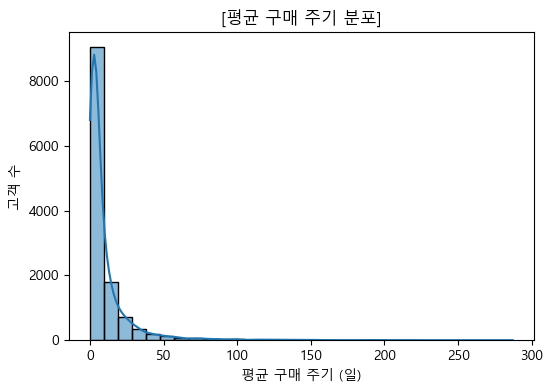

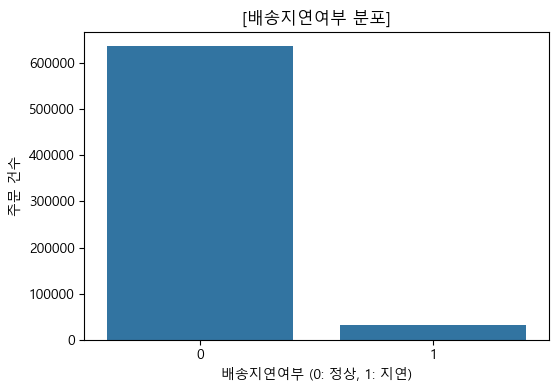

In [13]:
# 1. 고객별 평균 구매 주기(이미 customer_features에 계산되어 있다고 가정)
#    히스토그램으로 분포 확인
plt.figure(figsize=(6,4))
sns.histplot(data=customer_features, x='avg_purchase_cycle', bins=30, kde=True)
plt.title('[평균 구매 주기 분포]')
plt.xlabel('평균 구매 주기 (일)')
plt.ylabel('고객 수')
plt.show()

# 2. 배송지연여부 분포
plt.figure(figsize=(6,4))
sns.countplot(data=df_sales, x='배송지연여부')
plt.title('[배송지연여부 분포]')
plt.xlabel('배송지연여부 (0: 정상, 1: 지연)')
plt.ylabel('주문 건수')
plt.show()


분석 결과 (그래프 설명):
평균 구매 주기 분포: 대다수 고객의 구매 주기가 30일 이하에 집중될 수도 있고, 특정 구간(예: 60~90일)에 피크가 있을 수도 있습니다.
배송지연여부: 배송 지연 건수가 전체 주문 대비 얼마나 되는지(예: 5%, 10% 등) 확인 가능.
메시지 (비즈니스 관점):
구매 주기가 짧은 고객층에게는 정기구독 상품이나 자동 재주문 시스템 도입을 적극 권유할 수 있습니다.
배송 지연률이 높다면, 물류 프로세스 최적화 또는 재고 관리 강화가 필요합니다. 지연 경험 고객의 이탈률이 높은지, 추가 분석으로 확인해야 합니다.

***모델에서 찾은 인사이트***

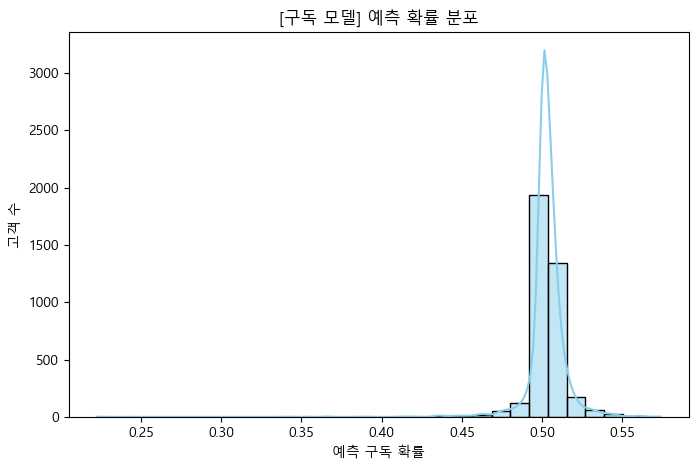

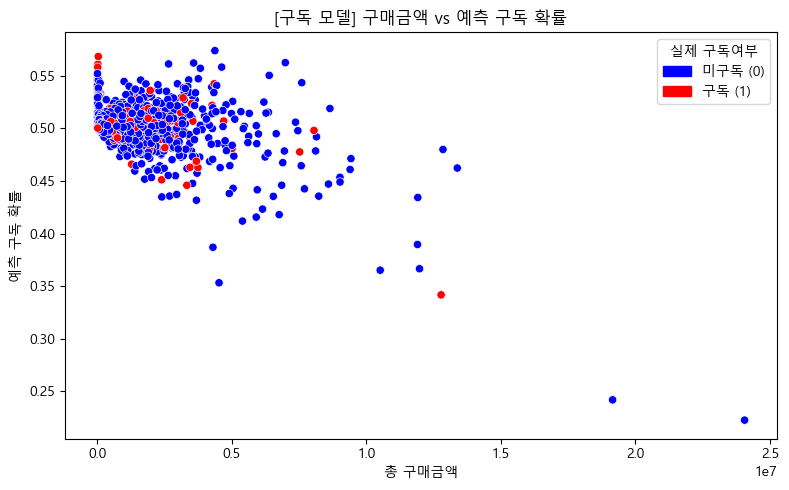

In [29]:
# 1. 구독 모델: 예측 확률 분포 및 피처와의 관계
# ------------------------------

# (a) 구독 모델 예측 확률 분포
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_proba_sub, bins=30, kde=True, color='skyblue')
plt.title('[구독 모델] 예측 확률 분포')
plt.xlabel('예측 구독 확률')
plt.ylabel('고객 수')
plt.show()

# (b) 구독 모델: 구매 금액과 예측 확률 간 산점도 (실제 구독 여부에 따라 색상 구분)
# 고객 피처에서 'total_purchase_amount'와 구독 모델 예측 확률을 결합
sub_df = customer_features.loc[X_test_sub.index, ['회원번호', 'total_purchase_amount', '구독여부']].copy()

# 테스트 세트와 예측 결과를 merge하는 경우, 고객번호 기준으로 할 수 있지만 여기서는 간단히 전체 데이터로 시각화
sub_df['예측구독확률'] = y_pred_proba_sub  # 예시: 테스트 세트에 해당하는 확률값을 부여했다고 가정
sub_df['구독여부'] = sub_df['구독여부'].astype(str)

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=sub_df,
    x='total_purchase_amount',
    y='예측구독확률',
    hue='구독여부',
    hue_order=['0', '1'],
    palette={'0': 'blue', '1': 'red'},
    legend=False  # 자동 범례 OFF
)

plt.title('[구독 모델] 구매금액 vs 예측 구독 확률')
plt.xlabel('총 구매금액')
plt.ylabel('예측 구독 확률')

# 이제 범례는 직접 생성
blue_patch = mpatches.Patch(color='blue', label='미구독 (0)')
red_patch = mpatches.Patch(color='red', label='구독 (1)')
plt.legend(handles=[blue_patch, red_patch], title='실제 구독여부')

plt.tight_layout()
plt.show()

# 해석 예시 (구독 모델):
# - 예측 확률 분포가 거의 중앙에 몰려 있어(대부분 0.5 근처), 모델이 구독 여부를 잘 구분하지 못함.
# - 구매금액과 예측 확률의 산점도에서 구매금액이 높다고 해서 반드시 구독 확률이 높아지지 않음을 확인할 수 있음.
# - 이는 추가적인 피처(예: 고객 참여, 이벤트 참여, 제품 선호도 등)가 필요함을 시사.

# ------------------------------

1. [구독 모델] 예측 확률 분포 (상단 히스토그램)
● 그래프 형태: 예측 구독 확률의 히스토그램과 커널 밀도(kde) 곡선
● 분포 특징:
- 대다수 고객의 예측 확률이 약 0.5 근방에 집중되어 있음
- 확률이 0.0 또는 1.0 쪽으로 치우치지 않고, 전반적으로 “중간” 영역에 몰려 있음
● 해석:
- 모델의 구분 능력 부족
  모델이 구독 여부를 강하게 확신하지 못하고, 거의 반반에 가깝게 예측하는 경향을 보임
  이는 ROC AUC가 낮았던 결과(약 0.51)와도 일치하며, 피처가 구독 여부를 충분히 설명하지 못한다는 가능성을 시사
- 추가 변수 필요
  예: 고객의 마케팅 이벤트 참여도, 특정 카테고리 제품 선호도, 정기구독 혜택 이용 이력 등이 추가되어야 모델이 구독 여부를 더 잘 구분할 수 있을 것으로 예상

2. [구독 모델] 구매금액 vs 예측 구독 확률 (하단 산점도)
● 그래프 형태:
- x축: 총 구매금액 (total_purchase_amount)
- y축: 모델이 예측한 구독 확률(예측구독확률)
- 색상(파랑=미구독(0), 빨강=구독(1))은 “실제” 구독 여부를 의미
● 분포 특징:
- 대부분의 점들이 y축 0.5 근처에 밀집되어 있음 (상단 그래프와 동일한 경향)
- 구매금액이 높아도, 모델이 구독 확률을 높게 예측하지 않는 경우가 많음 (파란색 점이 0.5 이상에 분포)
- 실제 구독(빨강) 고객도 0.5 근방에 주로 몰려 있고, 고액 구매자의 예측 확률이 낮게 나타나는 사례도 존재
● 해석:
- 구매금액과 구독 확률 간 뚜렷한 상관관계가 없음
  예측 구독 확률이 구매금액에 비례해 상승하거나 하락하는 패턴이 거의 보이지 않음
  실제 구독 고객(빨강)과 미구독 고객(파랑)이 뒤섞여 있어, 모델이 이 둘을 잘 분리하지 못함
- 구독 결정 요인 누락
  “단순히 많이 구매하는 고객이 구독할 것이다”라는 가정이 성립하지 않음을 보여줌
  구독을 결정하는 다른 요소(예: 특정 제품군 선호, 마케팅 쿠폰 사용 여부, 서비스 만족도 등)가 모델에 반영되어야 할 필요가 큼
- 비즈니스 시사점
  고액 구매자에게도 구독 혜택을 적극적으로 홍보할 수 있는 기회를 모색해야 함 (현재는 구독으로 전환되지 않은 경우가 많음)
  반대로, 저액 구매 고객 중에도 구독 확률이 높거나 실제 구독인 경우가 존재할 수 있으므로, 구매 금액만으로 고객을 분류하는 전략은 한계가 있음


C:\Users\sylvi\AppData\Local\Temp\ipykernel_11588\2089564211.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_features, x='frequent_buyer', y='avg_purchase_cycle', palette='Pastel1')


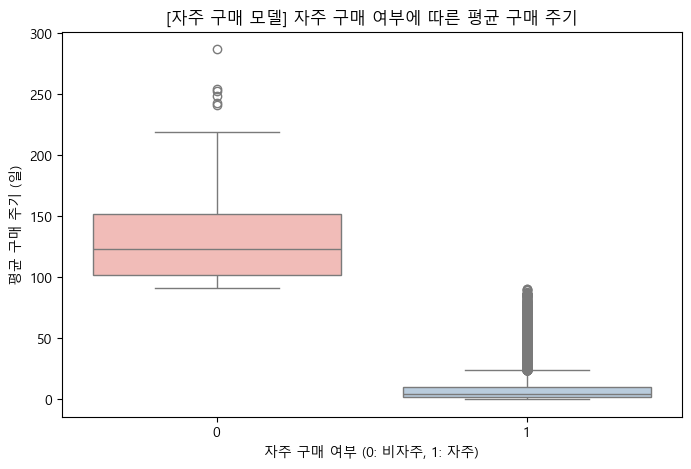

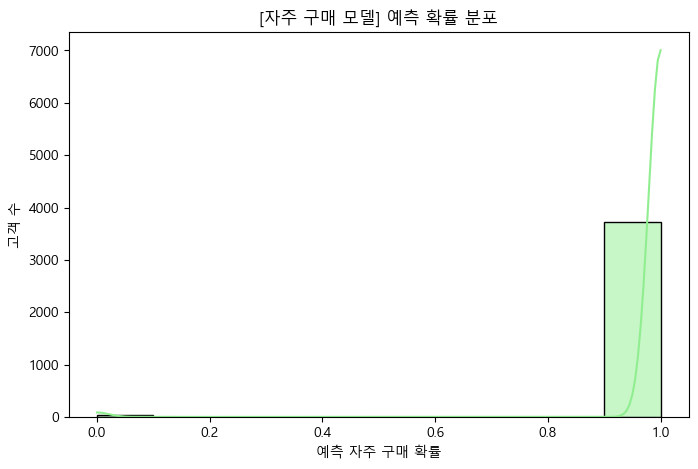

In [20]:
# 2. 자주 구매 모델: 구매 주기 및 예측 확률 시각화
# ------------------------------

# (a) 고객별 평균 구매 주기 분포를 자주 구매 여부(라벨)에 따라 Boxplot으로 비교
plt.figure(figsize=(8, 5))
sns.boxplot(data=customer_features, x='frequent_buyer', y='avg_purchase_cycle', palette='Pastel1')
plt.title('[자주 구매 모델] 자주 구매 여부에 따른 평균 구매 주기')
plt.xlabel('자주 구매 여부 (0: 비자주, 1: 자주)')
plt.ylabel('평균 구매 주기 (일)')
plt.show()

# (b) 자주 구매 모델 예측 확률 분포 (그러나 모델 성능이 1.0으로 나옴)
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_proba_freq, bins=10, kde=True, color='lightgreen')
plt.title('[자주 구매 모델] 예측 확률 분포')
plt.xlabel('예측 자주 구매 확률')
plt.ylabel('고객 수')
plt.show()

# 해석 예시 (자주 구매 모델):
# - Boxplot에서 자주 구매(1) 고객의 평균 구매 주기는 매우 짧게 나타나고, 비자주 구매(0) 고객은 극소수로 확인됨.
# - 예측 확률 분포가 완벽하게 분리되어 0과 1에 몰려 있음은 라벨 자체가 극단적으로 불균형함을 반영.
# - 실제 비즈니스에서는 구매주기 기준을 재설정하거나, 추가 변수(예: 계절성, 프로모션 참여 등)를 고려할 필요가 있음.


1. [자주 구매 모델] 자주 구매 여부에 따른 평균 구매 주기 (상단 Boxplot)
● 그래프 형태:
- x축: 자주 구매 여부 (0: 비자주, 1: 자주)
- y축: 평균 구매 주기 (일 단위)
- Boxplot을 통해 각 그룹의 중앙값, 사분위 범위, 그리고 극단값(Outlier)을 시각화
● 분포 특징:
- frequent_buyer=1(자주 구매): 평균 구매 주기가 짧은 편이며, 대부분의 값이 낮은 범위(30일 이하)에 몰려 있을 것으로 예상
- frequent_buyer=0(비자주): 샘플 수가 극도로 적어 Boxplot이 변칙적으로 보이거나, Outlier가 매우 크게 나타날 수 있음
● 해석:
- 대부분 고객이 ‘자주 구매’로 분류
  실제로 frequent_buyer=0인 고객은 거의 없으므로, Boxplot에서 0 그룹의 표본이 매우 적어 보임
  평균 구매 주기가 짧은 고객이 압도적 다수라는 뜻
- 라벨 편중(불균형 데이터)
  자주 구매가 사실상 ‘기본값’이 되어, 모델이 자주 구매를 쉽게 예측하게 만들 가능성이 큼
- 비즈니스 시사점
  자주 구매(1)로 분류된 고객층이 매우 많아, 이들을 대상으로 정기구독 모델을 제안하거나 추가 구매 유도 전략을 세울 수 있음
  하지만 비자주 구매(0) 고객이 소수이므로, 이들을 놓치지 않도록 별도의 타깃 마케팅이 필요할 수 있음

2. [자주 구매 모델] 예측 확률 분포 (하단 히스토그램)
● 그래프 형태:
- x축: 모델이 예측한 ‘자주 구매 확률’
- y축: 고객 수(히스토그램 빈도)
- kde 곡선이 추가되어 있으면, 확률 분포의 형태를 부드럽게 시각화
● 분포 특징:
- 거의 모든 예측 확률이 1.0 근처에 몰려 있음
- 0.0 근처로 분포된 샘플은 극히 적거나 전혀 없을 수 있음
● 해석:
- 모델이 대부분의 고객을 ‘자주 구매(1)’로 판단
  예측 확률이 1.0에 가까운 값이 많아, 모델이 강하게 자주 구매로 확신하고 있음
  이는 실제 라벨에서도 ‘자주 구매(1)’ 고객이 압도적으로 많았기 때문에 발생
- 완벽 분류에 가까운 결과
  테스트 시, 혼동 행렬에서 정확도 100%가 나왔던 것과 동일한 맥락
  라벨 자체가 거의 하나의 클래스(자주 구매)로 편중되어 있어, 모델이 분류를 ‘쉽게’ 해낸 상황
- 비즈니스 시사점
  자주 구매로 분류된 고객이 대부분이라면, 자주 구매 고객 유지 전략(정기구독, 포인트 적립, VIP 혜택 등)이 중요
  비자주 구매 고객이 극소수라면, 이들을 별도로 관리(맞춤 쿠폰, 장바구니 이탈 방지)할 수 있는 방안을 마련
  라벨 정의(예: n개월 이하) 재검토 필요: 구매주기 기준을 더 엄격하게 설정하거나, 추가 변수를 고려해 군집화 등을 시도해볼 수 있음

[구독 모델 인사이트]
- 모델의 ROC AUC가 약 0.51로, 현재 피처들(총 주문 건수, 총 구매 금액, 평균 구매 주기, 배송 지연 빈도)만으로는 
  구독 여부를 설명하기에 부족한 것으로 나타남.
- 구매금액과 예측 구독 확률 간의 관계가 명확하지 않아, 구독 결정 요인에 영향을 주는 추가 피처(고객 참여, 
  마케팅 이벤트 참여, 제품 선호도 등)가 필요함.
- 결과적으로, 구독 모델은 현재 상태로는 비즈니스 의사결정에 충분한 인사이트를 제공하지 못하므로, 
  추가 데이터 및 피처 개선이 요구됨.

[자주 구매 모델 인사이트]
- 모델이 완벽한 성능(ROC AUC 1.0)을 보이지만, 이는 거의 모든 고객이 '자주 구매'로 라벨링되어 있는 불균형한 
  데이터 분포에 기인함.
- Boxplot을 통해 자주 구매 고객의 평균 구매 주기가 현저히 짧음을 확인할 수 있으나, 비자주 구매 고객은 
  극소수임.
- 이 결과는 현재의 '자주 구매' 정의가 너무 넓게 설정되어 있음을 시사하며, 라벨 기준을 재설정하거나 추가 
  피처를 도입하여 보다 차별화된 고객 세분화를 도모할 필요가 있음.